---------------------Data Exploration & Cleaning---------------------

In [2]:
#Loading Data
import pandas as pd

products = pd.read_csv("products.csv")
users = pd.read_csv("users.csv")
orders = pd.read_csv("orders.csv")
reviews = pd.read_csv("reviews.csv")


In [3]:
# Inspecting Data
print(products.head())
print(users.info())
print(orders.describe())
print(reviews.isnull().sum())


  ProductID            ProductName     Category  Price
0     P0001     Samsung Galaxy A54  Electronics  18999
1     P0002        Apple iPhone 14  Electronics  69999
2     P0003      OnePlus Nord CE 3  Electronics  23999
3     P0004  Nike Air Zoom Pegasus      Fashion   8999
4     P0005      Adidas Ultraboost      Fashion  10999
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   UserID    500 non-null    object
 1   Name      500 non-null    object
 2   JoinDate  500 non-null    object
 3   Location  500 non-null    object
dtypes: object(4)
memory usage: 15.8+ KB
None
         Quantity  ReviewRating    OrderAmount
count  2000.00000   2000.000000    2000.000000
mean      1.04700      4.643000    9806.503000
std       0.24662      0.483392   19320.472919
min       1.00000      3.000000     149.000000
25%       1.00000      4.000000     399.000000
50%       

Cleaning Data

In [24]:
# Convert dates
orders['OrderDate'] = pd.to_datetime(orders['OrderDate'])
reviews['ReviewDate'] = pd.to_datetime(reviews['ReviewDate'])

# handle duplicates
orders.drop_duplicates(inplace=True)
reviews.drop_duplicates(inplace=True)

# Merge prices into orders:
orders = orders.drop(columns=['Price'], errors='ignore')# dropping old price column in ordes.csv
orders = orders.merge(products[['ProductID','Price']], on='ProductID')

# Calculate TotalAmount
orders['TotalAmount'] = orders['Quantity'] * orders['Price']

#Save the cleaned dataset:
orders.to_csv("cleaned_orders.csv", index=False)


---------------------SALES ANALYSIS---------------------

1. Top selling Products

In [27]:
top_products = orders.groupby("ProductID")['Quantity'].sum().reset_index()
top_products = top_products.merge(products[['ProductID','ProductName']], on='ProductID')
top_products = top_products.sort_values(by="Quantity", ascending=False).head(10)


visualizaton

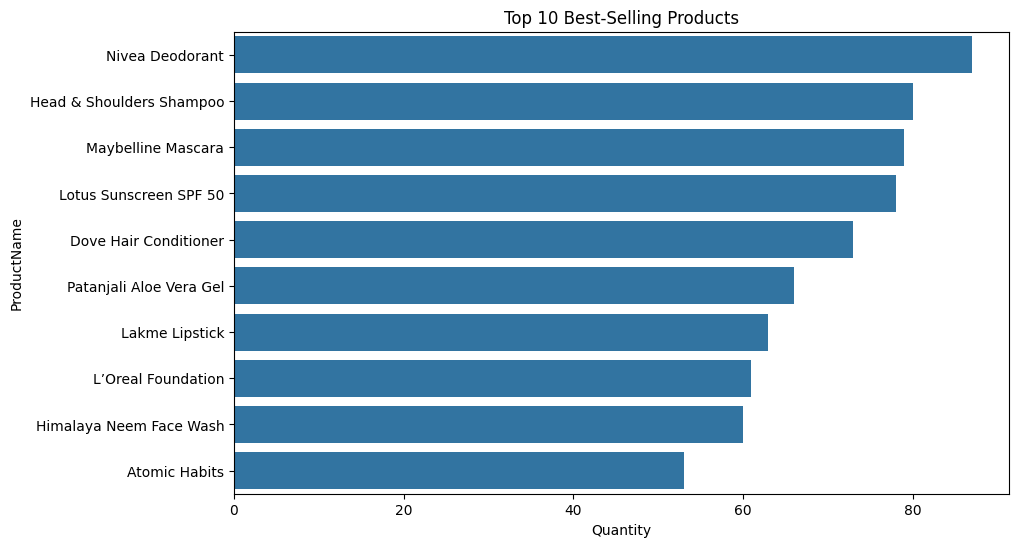

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(x="Quantity", y="ProductName", data=top_products)
plt.title("Top 10 Best-Selling Products")
plt.show()


2. Revenue by Category

In [31]:
orders = orders.merge(products[['ProductID', 'Category']], on='ProductID')
category_sales = orders.groupby("Category")['TotalAmount'].sum().reset_index()


Pie chart

<Axes: ylabel='TotalAmount'>

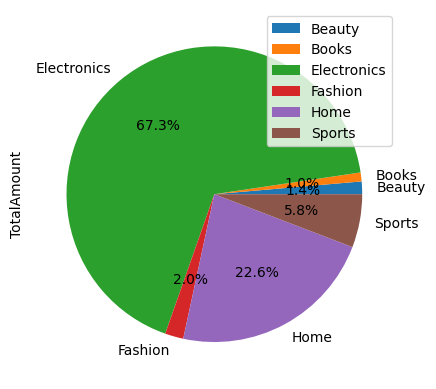

In [33]:
category_sales.plot.pie(y="TotalAmount", labels=category_sales["Category"], autopct="%1.1f%%")


3. Peak Hours of Sales

In [34]:
orders['Hour'] = orders['OrderDate'].dt.hour
hourly_sales = orders.groupby('Hour')['TotalAmount'].sum().reset_index()


Line chart

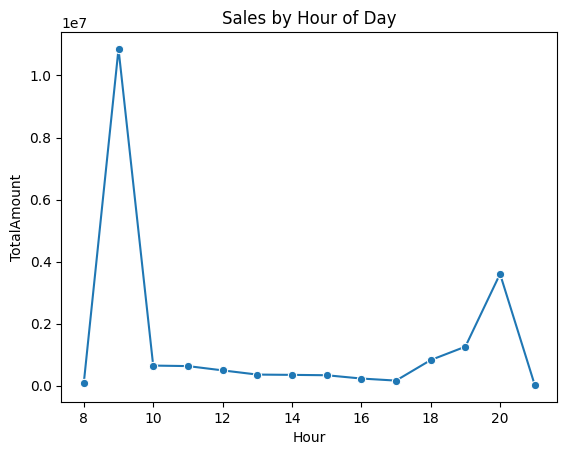

In [35]:
sns.lineplot(x='Hour', y='TotalAmount', data=hourly_sales, marker="o")
plt.title("Sales by Hour of Day")
plt.show()


---------------------USER BEHAVIOUR & RETENTION---------------------

1. Repeat Customers

In [47]:
# removing extra spaces from columns
orders.columns = orders.columns.str.strip()
print(orders.columns)

# Repeat Customers
repeat_customers = orders.groupby("UserID")['OrderID'].nunique().reset_index()
repeat_customers['Repeat'] = repeat_customers['OrderID'] > 1
repeat_rate = repeat_customers['Repeat'].mean() * 100

print("Repeat Customer Rate:", round(repeat_rate, 2), "%")




Index(['OrderID', 'UserID', 'ProductID', 'Quantity', 'OrderDate',
       'ReviewRating', 'OrderAmount', 'Price_x', 'Price_y', 'TotalAmount',
       'Price', 'Category', 'Hour'],
      dtype='object')
Index(['OrderID', 'UserID', 'ProductID', 'Quantity', 'OrderDate',
       'ReviewRating', 'OrderAmount', 'Price_x', 'Price_y', 'TotalAmount',
       'Price', 'Category', 'Hour'],
      dtype='object')
Repeat Customer Rate: 80.15 %


2. High-Value Customers

In [48]:
customer_value = orders.groupby("UserID")['TotalAmount'].sum().reset_index()
top_customers = customer_value.sort_values(by="TotalAmount", ascending=False).head(10)


3. Review Insights

In [50]:
avg_ratings = reviews.groupby("ProductID")['ReviewRating'].mean().reset_index()
avg_ratings = avg_ratings.merge(products[['ProductID','ProductName']], on='ProductID')
top_rated = avg_ratings.sort_values(by="ReviewRating", ascending=False).head(10)


Text(0.5, 1.0, 'Top 10 Products by Rating')

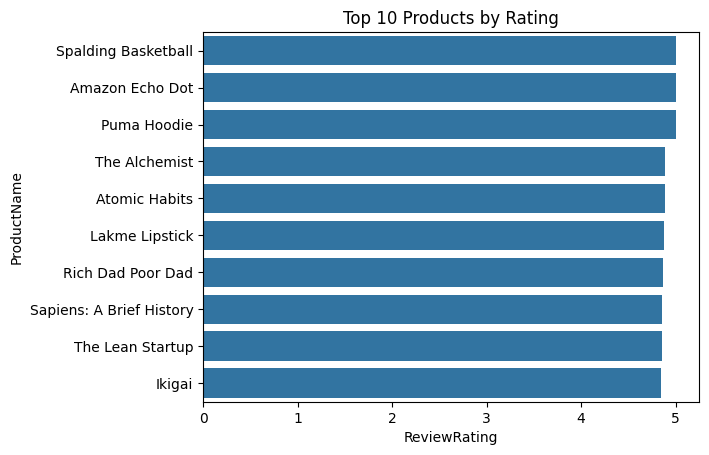

In [51]:
# Visualize with:

sns.barplot(x="ReviewRating", y="ProductName", data=top_rated)
plt.title("Top 10 Products by Rating")


---------------------BUILD INSIGHTS DASHBOARD---------------------

In [53]:
import plotly.express as px

fig = px.bar(top_products, x='Quantity', y='ProductName', title="Top Selling Products")
fig.show()
